# Objectives
After completing this lab, you will be able to:

- Use Amazon SageMaker to create a hyperparameter training job

- Tune an XGBoost model by using Amazon SageMaker

- Test the tuned model by using performance metrics

## Información general
Este laboratorio es una continuación de los laboratorios guiados del Módulo 3.

En este laboratorio, creará un trabajo de ajuste de hiperparámetros para ajustar el modelo que creó anteriormente. A continuación, comparará las métricas de los dos modelos.

## Presentación de la situación empresarial
Trabaja para un proveedor de atención médica y desea mejorar la detección de anomalías en los pacientes de ortopedia.

Se le asignó la tarea de resolver este problema con el uso de machine learning (ML). Tiene acceso a un conjunto de datos que contiene seis funciones biomecánicas y un objetivo de normal o anormal. Puede usar este conjunto de datos para entrenar un modelo de ML para predecir si un paciente tendrá una anomalía.

## Acerca de este conjunto de datos
Este conjunto de datos biomédicos fue creado por el Dr. Henrique da Mota durante un periodo de residencia médica en el Group of Applied Research in Orthopaedics (GARO) del Centre Médico-Chirurgical de Réadaptation des Massues, Lyon, Francia. Los datos se organizaron en dos tareas de clasificación diferentes pero que se relacionan.

La primera tarea consiste en clasificar pacientes como pertenecientes a una de tres categorías:

Normal (100 pacientes)
Hernia de disco (60 pacientes)
Espondilolistesis (150 pacientes)
Para la segunda tarea, las categorías hernia de disco y espondilolistesis se fusionaron en una sola categoría que se denomina anormal. Por ende, la segunda tarea consiste en clasificar a los pacientes como pertenecientes a una de dos categorías: normal (100 pacientes) o anormal (210 pacientes).

## Información de atributos
Cada paciente está representado en el conjunto de datos por seis atributos biomecánicos que se derivan de la forma y la orientación de la pelvis y la columna lumbar (en este orden):

Pelvic incidence (Incidencia pélvica)
Pelvic tilt (Inclinación pélvica)
Lumbar lordosis angle (Ángulo de lordosis lumbar)
Sacral slope (Pendiente sacra)
Pelvic radius (Radio pélvico)
Grade of spondylolisthesis (Grado de espondilolistesis)
Se usa la siguiente convención para las etiquetas de clase:

DH (hernia de disco)
SL (espondilolistesis)
NO (normal)
AB (anormal)
Para obtener más información sobre este conjunto de datos, consulte la página web del conjunto de datos de la columna vertebral.

## Atribuciones del conjunto de datos
Este conjunto de datos se obtuvo de: Dua, D. y Graff, C. (2019). Repositorio de Machine Learning de UCI (http://archive.ics.uci.edu/ml). Irvine, CA: Universidad de California, School of Information and Computer Science.

# Configuración del laboratorio

Debido a que esta solución se divide en varios laboratorios en el módulo, debe ejecutar las siguientes celdas para poder cargar los datos y entrenar el modelo que se implementará.

**Nota:** La configuración puede tardar hasta 5 minutos en completarse.

## Importación de los datos y entrenamiento, prueba y validación del modelo

Ejecute las siguientes celdas para importar los datos, entrenar, probar y validar el modelo y dejarlo listo para utilizarse. 

**Nota:** Las siguientes celdas representan los pasos clave de los laboratorios anteriores.

Para ajustar el modelo, debe estar listo y, luego, se puede afinar con hiperparámetros en el paso 2.

# Desde tu terminal (PowerShell o CMD, no en el notebook) crea y activa el entorno con Python 3.12:
    
py -3.12 -m venv venv

.\venv\Scripts\activate   # PowerShell

pip install requests pandas scipy boto3 sagemaker scikit-learn seaborn matplotlib ipykernel xgboost

python -m ipykernel install --user --name=venv --display-name "Python 3.12 (venv)"


In [ ]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#
import xgboost as xgb


sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\Rodrigo\AppData\Local\sagemaker\sagemaker\config.yaml


**Nota:** La siguiente celda tarda aproximadamente **10** minutos en completarse. Observe el código y cómo se procesa, esto le permite entender mejor lo que sucede en segundo plano. Tenga presente que esta celda completa todos los pasos que hizo en laboratorios anteriores de este módulo, entre ellos:
 - Importación de los datos
 - Carga de los datos en un DataFrame
 - División de los datos en conjuntos de datos de entrenamiento, prueba y validación
 - Carga de los conjuntos de datos divididos en S3
 - Entrenamiento, prueba y validación del modelo con los conjuntos de datos

pip install awscli
aws configure
C:\Users\Rodrigo\.aws

[default]
aws_access_key_id=aws_access_key_id
aws_secret_access_key=aws_secret_access_key
aws_session_token=aws_session_token

In [3]:
bucket='c174660a4519473l11469662t1w975050097455-labbucket-shf2otxd36wy'

Sensitivity or TPR: 85.71%
Specificity or TNR: 70.00%
Precision: 85.71%
Negative Predictive Value: 70.00%
False Positive Rate: 30.00%
False Negative Rate: 14.29%
False Discovery Rate: 14.29%
Accuracy: 80.65%
Validation AUC: 0.8904761904761905


<timed exec>:89: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\Projects\inacap\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


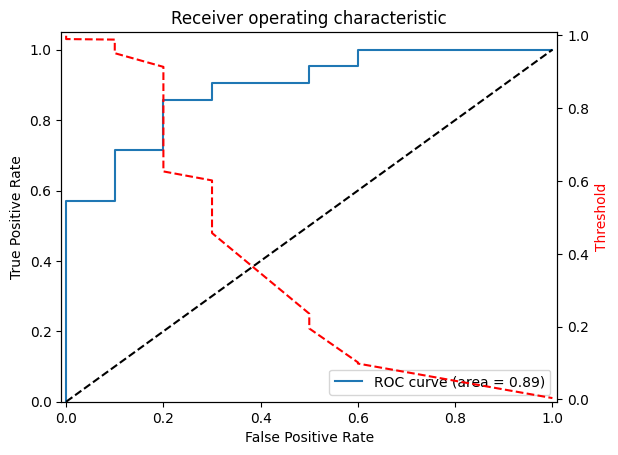

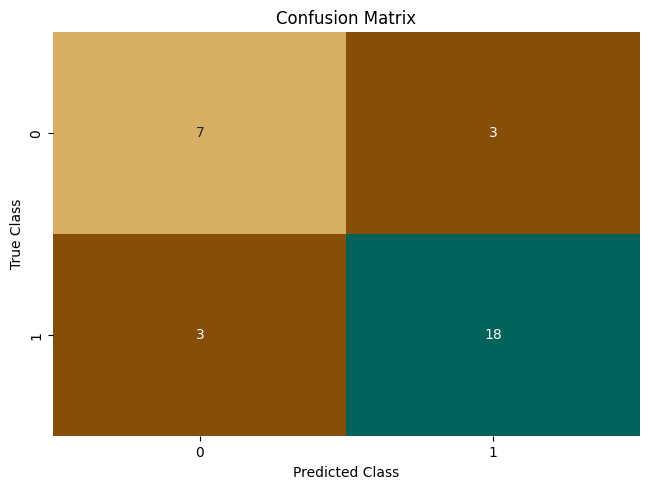

CPU times: total: 578 ms
Wall time: 851 ms


In [7]:
%%time
import pandas as pd
import numpy as np
import requests, io, zipfile
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# =========================
# 🔹 Funciones de evaluación
# =========================
def plot_roc(test_labels, target_predicted_prob):
    # convertir a binario para métricas de confusion
    target_predicted_binary = (target_predicted_prob >= 0.5).astype(int)
    
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    Sensitivity  = TP / (TP + FN) * 100
    Specificity  = TN / (TN + FP) * 100
    Precision = TP / (TP + FP) * 100
    NPV = TN / (TN + FN) * 100
    FPR = FP / (FP + TN) * 100
    FNR = FN / (TP + FN) * 100
    FDR = FP / (TP + FP) * 100
    ACC = (TP + TN) / (TP + FP + FN + TN) * 100

    print(f"Sensitivity or TPR: {Sensitivity:.2f}%")    
    print(f"Specificity or TNR: {Specificity:.2f}%") 
    print(f"Precision: {Precision:.2f}%")   
    print(f"Negative Predictive Value: {NPV:.2f}%")  
    print(f"False Positive Rate: {FPR:.2f}%") 
    print(f"False Negative Rate: {FNR:.2f}%")  
    print(f"False Discovery Rate: {FDR:.2f}%")
    print(f"Accuracy: {ACC:.2f}%") 

    print("Validation AUC:", roc_auc_score(test_labels, target_predicted_prob))

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    delta = 0.01  # 1%
    # 1️⃣ Filtrar los valores NaN o Inf
    thresholds = thresholds[np.isfinite(thresholds)]
    ax2.set_ylim([thresholds[-1] - delta, thresholds[0] + delta])
    ax2.set_xlim([fpr[0] - delta, fpr[-1] + delta])

    plt.show()


def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='d', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

# =========================
# 🔹 Cargar dataset
# =========================
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

# Convertir clase a 0/1
class_mapper = {b'Abnormal':1, b'Normal':0}
# df['class'] = df['class'].replace(class_mapper)
df['class'] = df['class'].replace(class_mapper).infer_objects()

# Reordenar columnas (clase primero)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# =========================
# 🔹 Split de datos
# =========================
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# =========================
# 🔹 Entrenar XGBoost local
# =========================
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}

bst = xgb.train(params, dtrain, num_boost_round=42)

# Predicciones
# y_pred_prob = bst.predict(dtest)
y_pred_prob = np.clip(bst.predict(dtest), 1e-6, 1 - 1e-6)
y_pred = (y_pred_prob > 0.5).astype(int)

# =========================
# 🔹 Evaluar modelo
# =========================
plot_roc(y_test, y_pred_prob)
plot_confusion_matrix(y_test, y_pred)
